Add hill shading

https://gis.stackexchange.com/questions/25099/choosing-colour-ramp-to-use-for-elevation

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import scipy.signal as signal

In [4]:
def extract_weightmap(im):
    "selects the non white part of the image"
    ww = np.zeros(shape=im.shape[:2])
    ww[np.where(im.sum(axis=2) < 4.)] = 1.
    return ww

def invert_weightmap(ww):
    return 1 - ww

In [5]:
map_oceans = plt.imread("../../maps/LOTR_MAPS_oceans.png")
map_rivers = plt.imread("../../maps/LOTR_MAPS_rivers.png")
map_hills = plt.imread("../../maps/LOTR_MAPS_hills.png")
map_mountains = plt.imread("../../maps/LOTR_MAPS_mountains.png")
map_ridges = plt.imread("../../maps/LOTR_MAPS_ridges.png")

In [6]:
wmap_oceans = extract_weightmap(map_oceans)
wmap_rivers = extract_weightmap(map_rivers)
wmap_hills = extract_weightmap(map_hills)
wmap_mountains = extract_weightmap(map_mountains)
wmap_ridges = extract_weightmap(map_ridges)

wmap_land = invert_weightmap(wmap_oceans)

In [7]:
np.random.seed(5)

In [8]:
sh = wmap_land.shape
num = sh[0] * sh[1]
values = np.random.uniform(size=num)

In [9]:
canvas = np.zeros(shape = wmap_land.shape)
canvas = values.reshape(canvas.shape)

In [10]:
ridge_heights = 8000 # the extra  max heights compared to baseline
mountain_heights = 1500
hill_heights = 600
land_heights = 10

In [11]:
raw_canvas = np.zeros(shape = wmap_land.shape)
raw_canvas = np.random.uniform(size=num).reshape(raw_canvas.shape)
canvas = raw_canvas * wmap_land
canvas = ((raw_canvas * wmap_land * land_heights) +
         (raw_canvas * wmap_hills * hill_heights) +
         (raw_canvas * wmap_mountains * mountain_heights) +
         (raw_canvas * wmap_ridges * ridge_heights)) 

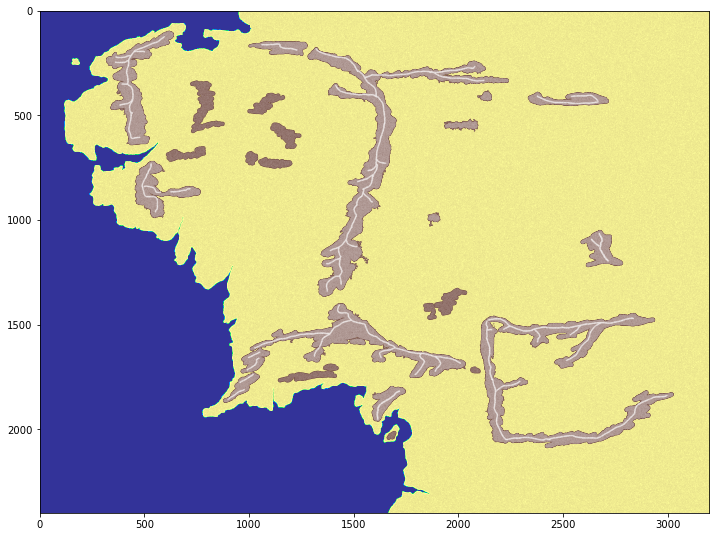

In [12]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(canvas + 0.001, cmap=plt.cm.terrain, norm=mpl.colors.LogNorm())

In [13]:
def distance_kernel(half_extent=50):
    size = half_extent * 2 + 1
    kernel = np.zeros((size, size))
    vals = np.arange(-half_extent,half_extent+1)
    xx, yy = np.meshgrid(vals, vals, indexing='xy')
    # y, x = np.ogrid[-half_extent:half_extent+1, -half_extent:half_extent+1]
    distance = np.sqrt(xx**2 + yy**2)
    return distance
    
def tophat(dists, scale=50.):
    kernel = np.zeros(dists.shape)
    kernel[dists < radius] = 1
    kernel = kernel / kernel.sum()
    return kernel

def gaussian(dists, scale=50.):
    kernel = np.zeros(dists.shape)
    kernel = np.exp(- dists**2. / (2 * scale**2.))
    kernel = kernel / kernel.sum()
    return kernel

def triangle(dists, scale=50):
    """triangle kernel, scale is when it hits zero"""
    kernel = np.zeros(dists.shape)
    kernel = scale - dists
    kernel[kernel < 0] = 0
    kernel = kernel / kernel.sum()
    return kernel
    

    
    


In [14]:
kernels = {
    "gauss": gaussian,
    "tophat": tophat,
    "triangle": triangle,
}

def make_noise_map(scale, shape, which="gauss"):
    num = shape[0] * shape[1]
    noise = np.random.uniform(size=num).reshape(shape)
    dists = distance_kernel(half_extent=scale*3)
    
    
    kern = kernels[which](dists, scale=scale)
    tmp = np.fft.irfft2(np.fft.rfft2(noise) * np.fft.rfft2(kern, noise.shape))
    tmp = tmp - tmp.min()
    tmp = tmp / tmp.max()
    
    return tmp
    

In [15]:
res = make_noise_map(100, raw_canvas.shape)

Text(0.5, 1.0, 'wavelength 100')

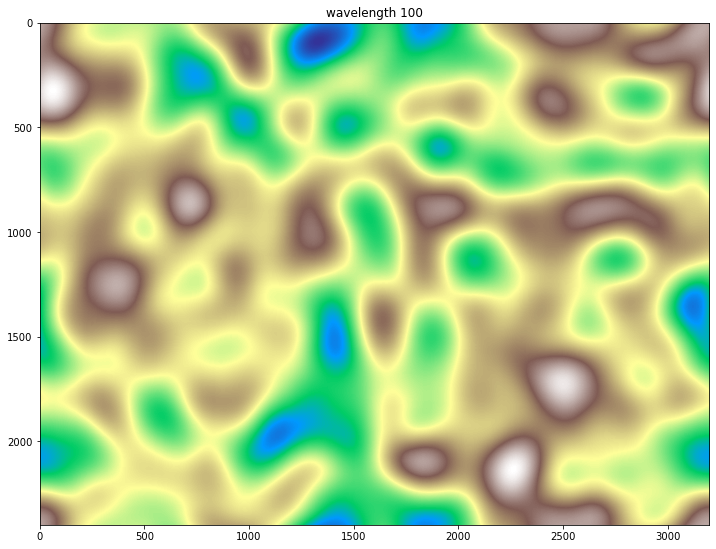

In [16]:

res = make_noise_map(100, raw_canvas.shape)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(res, cmap=plt.cm.terrain)
ax.set_title("wavelength 100")

Text(0.5, 1.0, 'wavelength 20')

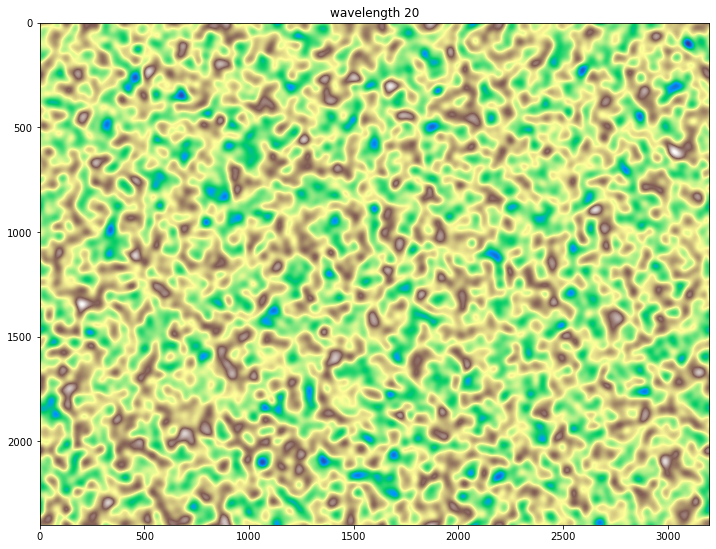

In [17]:

res = make_noise_map(20, raw_canvas.shape)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(res, cmap=plt.cm.terrain)
ax.set_title("wavelength 20")

In [18]:
ridge_heights = 8000
mountain_heights = 2000
hill_heights = 700
land_heights = 50

land_scale = 200
hill_scale = 20
mountain_scale = 5
ridge_scale = 2

heights = [land_heights, hill_heights, mountain_heights, ridge_heights]
scales = [land_scale, hill_scale, mountain_scale, ridge_scale]
wmaps = [wmap_land, wmap_hills, wmap_mountains, wmap_ridges]

In [19]:
raw_canvas = np.zeros(shape = wmap_land.shape)
canvas = raw_canvas.copy()

for i, (height, scale) in enumerate(zip(heights, scales)):
    print(height, scale)
    canvas += wmaps[i] * make_noise_map(scale, canvas.shape) * height

50 200
700 20
2000 5
8000 2


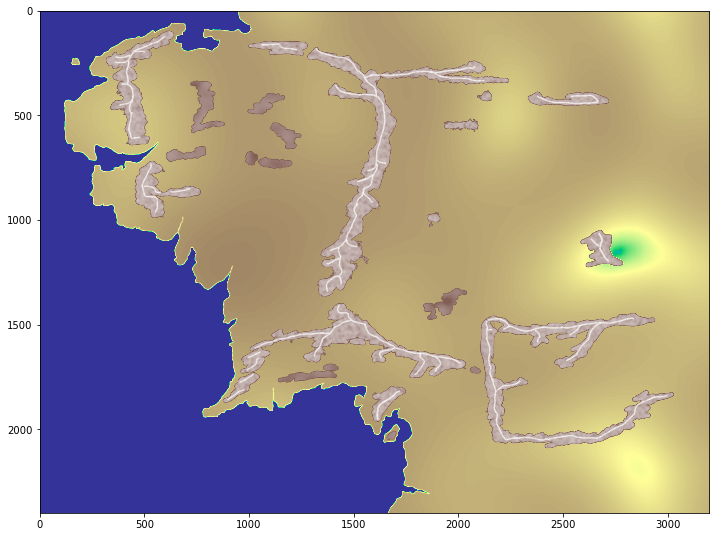

In [20]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(canvas, cmap=plt.cm.terrain)
ax.imshow(canvas + 0.001, cmap=plt.cm.terrain, norm=mpl.colors.LogNorm())

In [21]:
def convolve_map(canvas, scale, which = "gauss", fill_value=0):
    pad_width = scale*5
    padded = np.pad(canvas, pad_width = pad_width, mode="edge")
    half_extent = scale*2
    dists = distance_kernel(half_extent = half_extent)    
    kern = kernels[which](dists, scale = scale)
    
    # There's some shape difference here, which needs to be manually corrected with the padding
    # just offset the convolved image by the half_extent of the kernel...
    tmp = np.fft.irfft2(np.fft.rfft2(padded) * np.fft.rfft2(kern, padded.shape))
    tmp = tmp[pad_width+half_extent:-pad_width+half_extent, pad_width+half_extent:-pad_width+half_extent]
    return tmp

In [22]:
wavelengths = [5, 20, 60, 180, 320, 480, 1000]
#wavelengths = np.round(np.logspace(np.log10(5), 2.7, 16)).astype(int)

ocean = wmap_oceans * -1000
omaps = []
for ww in wavelengths:
    print(ww)
    tmp = convolve_map(ocean, ww, which = "gauss", fill_value=-1000) * wmap_oceans
    omaps.append(tmp)

5
20
60
180
320
480
1000


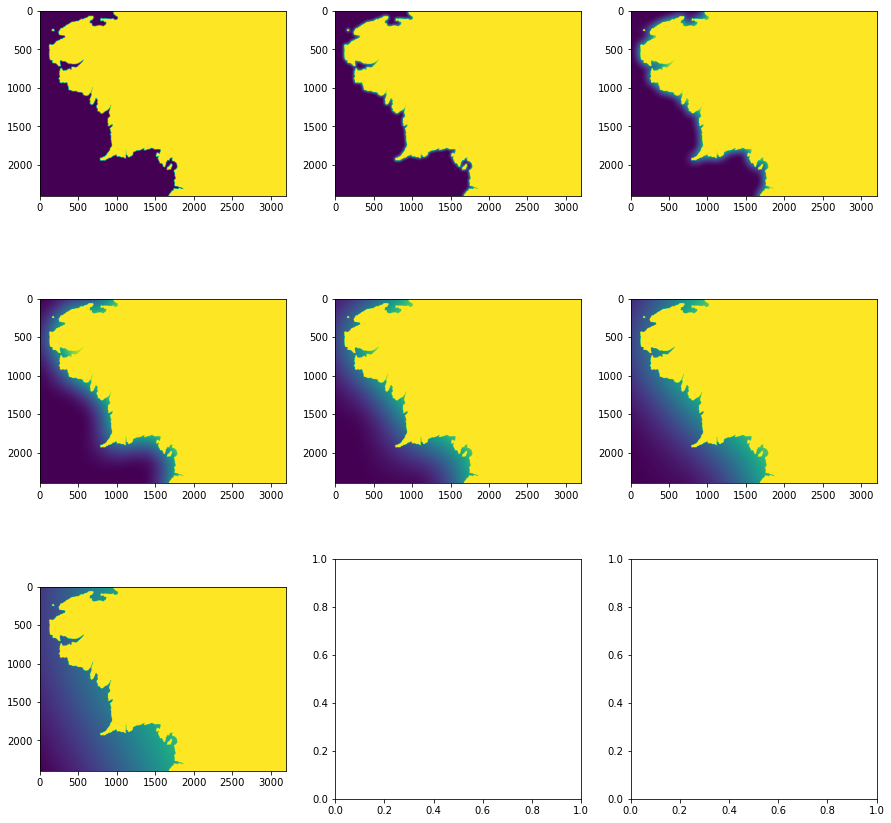

In [23]:
fig, axarr = plt.subplots(3, 3, figsize=(15, 15))
faxarr = axarr.flatten()

for i, ww in enumerate(wavelengths):
    try:
        faxarr[i].imshow(omaps[i])
#         faxarr[i].set_title(ww)
    except:
        pass

In [24]:

wavelengths = [5, 10, 20, 30, 60, 90, 180, 340, 460]

maps = []
for ww in wavelengths:
    print(ww)
    tmp = convolve_map(canvas, ww, which = "gauss") * wmap_land
    maps.append(tmp)

5
10
20
30
60
90
180
340
460


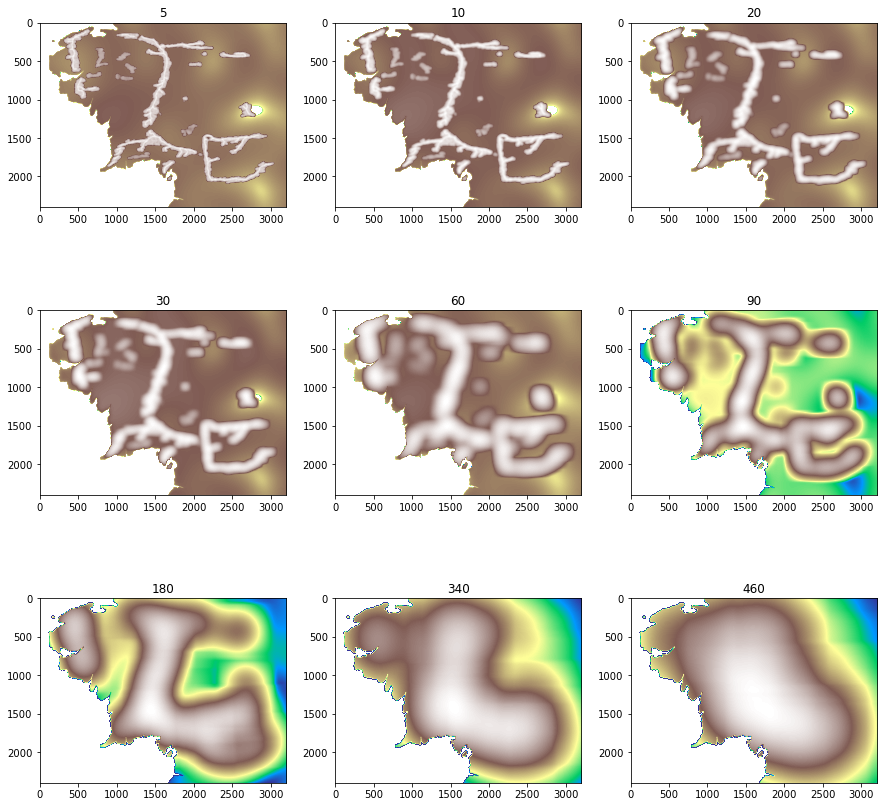

In [25]:
fig, axarr = plt.subplots(3, 3, figsize=(15, 15))
faxarr = axarr.flatten()

for i, ww in enumerate(wavelengths):
    faxarr[i].imshow(maps[i] -1, cmap=plt.cm.terrain, norm=mpl.colors.LogNorm())
    faxarr[i].set_title(ww)

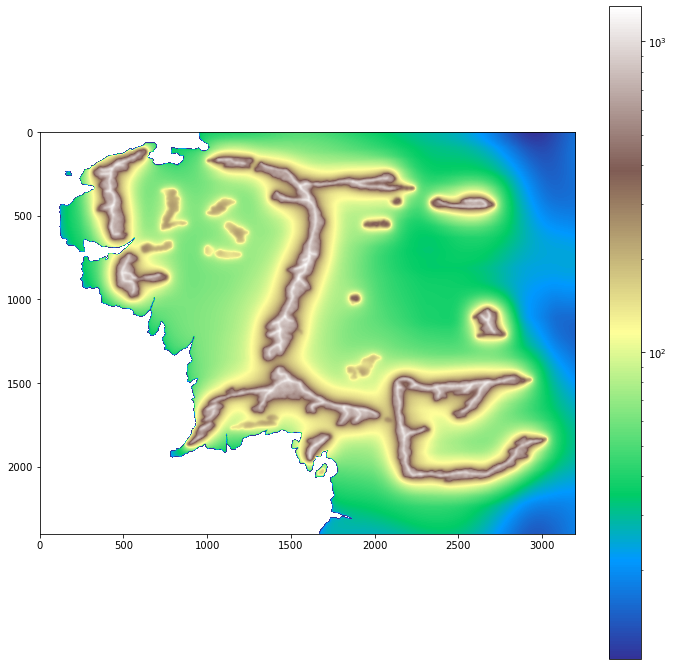

In [26]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cobj = ax.imshow(np.array(maps).mean(axis=0) -1, cmap=plt.cm.terrain, norm=mpl.colors.LogNorm())
fig.colorbar(cobj)

In [27]:
len(omaps)

7

In [28]:
weights = np.array([1, 1, 1, 2, 3, 4, 5])

In [42]:
lmap = np.average(maps, axis=0)
omap = np.average(omaps, weights=weights, axis=0)
newmap = lmap + omap

In [43]:
np.save("newheightmap.npy", newmap)

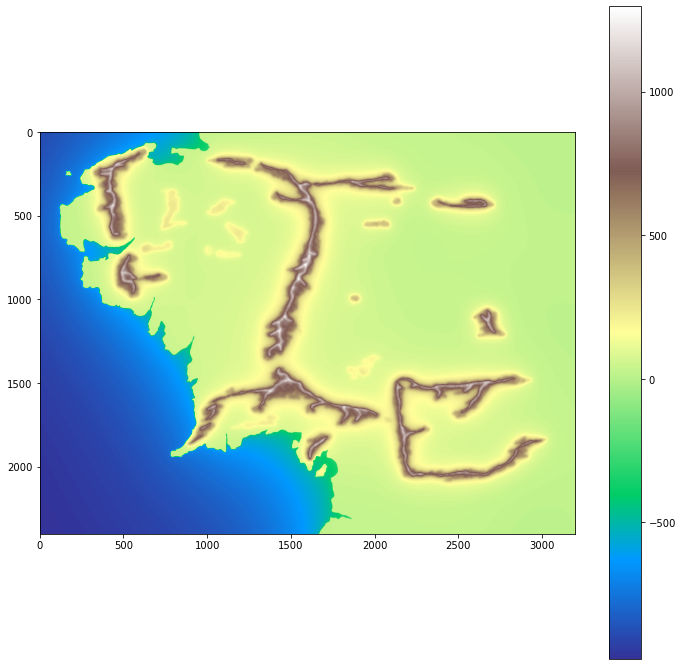

In [30]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cobj = ax.imshow(omap + lmap, cmap="terrain")
fig.colorbar(cobj)

# custom colorbar

In [31]:
xx = np.linspace(0, 1, 100)
yy = np.zeros(len(xx))
cvals = plt.cm.terrain(xx)

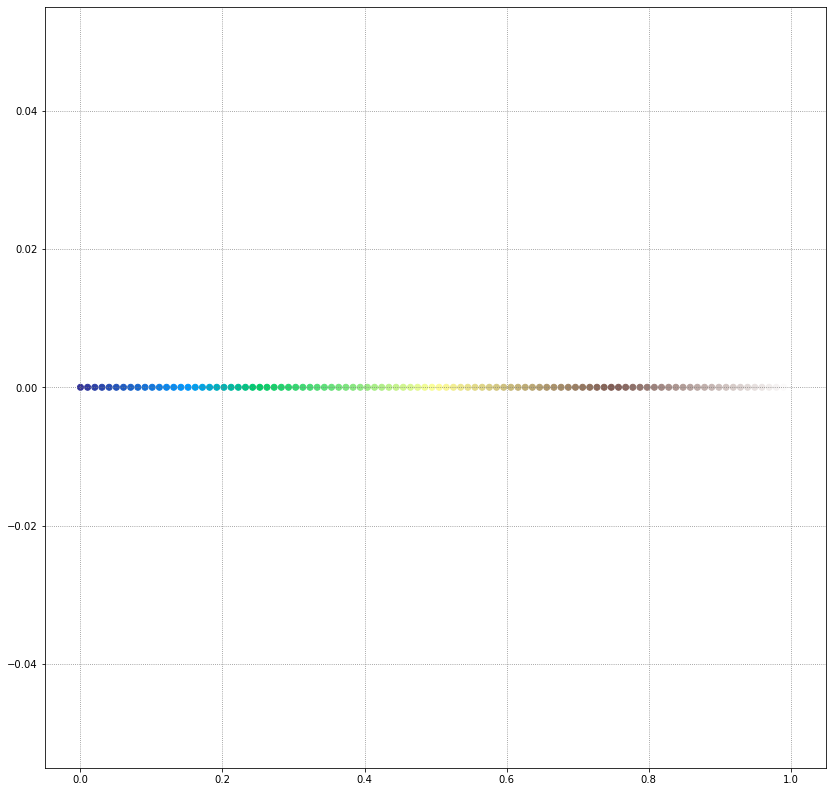

In [32]:
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111)
ax.scatter(xx, yy, c = cvals)
ax.grid(ls=":", color="gray")

In [33]:
import matplotlib

class FixPointNormalize(matplotlib.colors.Normalize):
    """ 
    Inspired by https://stackoverflow.com/questions/20144529/shifted-colorbar-matplotlib
    Subclassing Normalize to obtain a colormap with a fixpoint 
    somewhere in the middle of the colormap.
    This may be useful for a `terrain` map, to set the "sea level" 
    to a color in the blue/turquise range. 
    """
    def __init__(self, vmin=None, vmax=None, sealevel=0, col_val = 0.21875, clip=False):
        # sealevel is the fix point of the colormap (in data units)
        self.sealevel = sealevel
        # col_val is the color value in the range [0,1] that should represent the sealevel.
        self.col_val = col_val
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.sealevel, self.vmax], [0, self.col_val, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [34]:
FixPointNormalize()

In [35]:
raw = omap + lmap

In [36]:
np.abs(raw.min()) / (raw.max() - raw.min())

0.4292409728339723

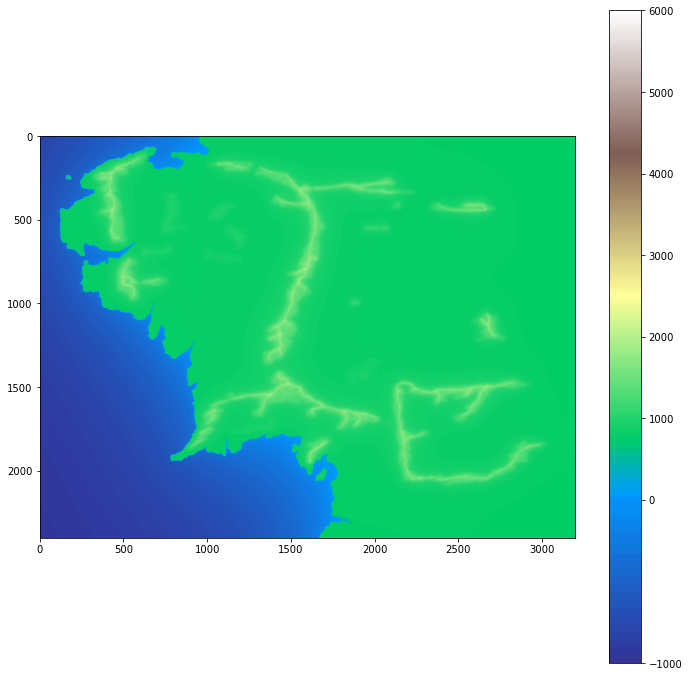

In [41]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cobj = ax.imshow(omap + lmap, cmap="terrain", norm=FixPointNormalize(vmin=-1000, vmax=6000, sealevel=0, col_val=0.25))
fig.colorbar(cobj)